In [19]:
#from multiprocessing import Pool
#from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import time
#from numba import jit

In [9]:
'''
    "score" = predicted value, should be single value
    pred() takes GBDT/RF outputs, i.e., the "score", as its inputs, and returns predictions.
    g() is the gradient/1st order derivative, which takes true values "true" and scores as input, and returns gradient.
    h() is the heassian/2nd order derivative, which takes true values "true" and scores as input, and returns hessian.
'''
class leastsquare(object):
    '''Loss class for mse. As for mse, pred function is pred=score.'''
    def pred(self, score):
        return score

    def g(self, true, score):
        #score_mat = np.ones(shape=true.shape) * score
        return -2*(true - score)

    def h(self, true, score):
        return 2*np.ones(shape=true.shape)

class logistic(object):
    '''Loss class for log loss. As for log loss, pred function is logistic transformation.'''
    def pred(self, score):
        prediction = 1 / (1 + np.exp(-score))
        prediction[prediction > 0.5] = 1
        prediction[prediction <= 0.5] = 0
        return prediction

    def g(self, true, score):
        score_mat = np.ones(shape=true.shape) * score
        return (-(np.exp(score_mat)*(true - 1) + true) / (np.exp(score_mat) + 1)) # From wolfram alpha

    def h(self, true, score):
        score_mat = np.ones(shape=true.shape) * score
        return np.exp(score_mat) / (np.exp(score_mat) + 1)**2 # From wolfram alpha

In [10]:
# TODO: class of GBDT
class GBDT(object):
    '''
    Class of gradient boosting decision tree (GBDT)
    
    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        loss: Loss function for gradient boosting.
            'mse' for regression task and 'log' for classfication task.
            A child class of the loss class could be passed to implement customized loss.
        max_depth: The maximum depth D_max of a tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf score, also known as lambda.
        gamma: The regularization coefficient for number of tree nodes, also know as gamma.
        learning_rate: The learning rate eta of GBDT.
        num_trees: Number of trees.
    '''
    def __init__(self,
        n_threads = None, loss = 'mse',
        max_depth = 3, min_sample_split = 10, 
        lamda = 1, gamma = 0,
        learning_rate = 0.1, num_trees = 100):
        
        self.n_threads = n_threads
        self.loss = loss
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.num_trees = num_trees

    def fit(self, train, target):
        # train is n x m 2d numpy array
        # target is n-dim 1d array
        
         # First, find our initial prediction y_0 which is the average of our inputted target value
        self.init_pred = np.mean(target)

        g = self.loss.g(target, self.init_pred)
        h = self.loss.h(target, self.init_pred)
        #print(g, h)

        # Generate self.num_trees
        for i in np.arange(self.num_trees):

            new_tree = Tree(n_threads = self.n_threads, max_depth = self.max_depth, min_sample_split = self.min_sample_split, lamda = self.lamda, gamma = self.gamma, rf = self.rf)
            new_tree.fit(train=train, target=target, g=g, h=h)
            self.trees.append(new_tree)

            # Update our values for g and h based on the previously created tree
            

        return self

    def predict(self, test):
        #TODO
        return self.loss.pred(score)

In [11]:
# TODO: class of Random Forest
class RF(object):
    '''
    Class of Random Forest
    
    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        loss: Loss function for gradient boosting.
            'mse' for regression task and 'log' for classfication task.
            A child class of the loss class could be passed to implement customized loss.
        max_depth: The maximum depth d_max of a tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf score, also known as lambda.
        gamma: The regularization coefficient for number of tree nodes, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule.
        num_trees: Number of trees.
    '''
    def __init__(self, n_threads = None, loss = 'mse', max_depth = 3, min_sample_split = 10, lamda = 1, gamma = 0, rf = 0.99, num_trees = 100):
        
        self.n_threads = n_threads

        if loss == 'mse':
            self.loss = leastsquare()
        elif loss == 'log':
            self.loss = logistic()
        else:
            print('Invalid loss function for RF object.')
            return self

        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.rf = rf
        self.num_trees = num_trees
        self.trees = []
        self.init_pred = 0

    def fit(self, train, target):
        # train is n x m 2d numpy array
        # target is n-dim 1d array

        # First, find our initial prediction y_0 which is the average of our inputted target value
        self.init_pred = np.mean(target)

        g = self.loss.g(target, self.init_pred)
        h = self.loss.h(target, self.init_pred)
        #print(g, h)

        # Generate self.num_trees
        for i in np.arange(self.num_trees):
            train_boot = np.random.choice(train.shape[0], size=train.shape[0], replace=True)

            new_tree = Tree(n_threads = self.n_threads, max_depth = self.max_depth, min_sample_split = self.min_sample_split, lamda = self.lamda, gamma = self.gamma, rf = self.rf)
            new_tree.fit(train=train[train_boot, :], target=target[train_boot], g=g[train_boot], h=h[train_boot])
            self.trees.append(new_tree)

        return self

    def predict(self, test):
        n, m = test.shape

        score = np.zeros(n)

        for tree in self.trees:
            tree_score = tree.predict(test)
            score += tree_score
        
        score = score / self.num_trees
        score += self.init_pred

        return self.loss.pred(score)
    
    def print(self):
        for tree in self.trees:
            tree.print()
        return self

In [12]:
# TODO: class of a node on a tree
class TreeNode(object):
    '''
    Data structure that are used for storing a node on a tree.
    
    A tree is presented by a set of nested TreeNodes,
    with one TreeNode pointing two child TreeNodes,
    until a tree leaf is reached.
    
    A node on a tree can be either a leaf node or a non-leaf node.
    '''
    
    def __init__(self, y_value = 0, split_feature = None, split_threshold = None, left_child = None, right_child = None, gain = 0):
        #[X1, X2, index_y, value_y] = split(X)
        if not left_child and not right_child:
            self.is_leaf = True
        else:
            self.is_leaf = False
        self.y_value = y_value
        self.left_child = left_child
        self.right_child = right_child
        self.split_feature = split_feature
        self.split_threshold = split_threshold
        self.gain = gain
        
    def forward(self, x):
        if x[self.split_feature] < self.split_threshold:
            return self.left_child
        else:
            return self.right_child
    
    def print(self):
        print('Is Leaf:', self.is_leaf, '| Value:', self.y_value, '| Split feature:', self.split_feature, '| Split Threshold:', self.split_threshold)

        if(self.is_leaf == False):
            self.left_child.print()
            self.right_child.print()

        return self

In [13]:
# TODO: class of single tree
class Tree(object):
    '''
    Class of a single decision tree in GBDT

    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        max_depth: The maximum depth of the tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf prediction, also known as lambda.
        gamma: The regularization coefficient for number of TreeNode, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule,
            rf = 0 means we are training a GBDT.
    '''
    
    def __init__(self, n_threads = None, max_depth = 3, min_sample_split = 10, lamda = 1, gamma = 0, rf = 0):
        self.n_threads = n_threads
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.rf = rf
        self.int_member = 0
        self.root_node = None

    def print(self):
        self.root_node.print()

        return self

    def fit(self, train, target, g, h):
        '''
        train is the training data matrix, and must be numpy array (an n_train x m matrix).
        g and h are gradient and hessian respectively.
        '''        
        n, m = train.shape

        self.root_node = self.construct_tree(train, target, g, h, 1)

        return self

    def predict(self, test):
        '''
        test is the test data matrix, and must be numpy arrays (an n_test x m matrix).
        Return predictions (scores) as an array.
        '''
        n, m = test.shape
        result = np.zeros(n)

        for i in np.arange(n):
            current_node = self.root_node
            test_current = test[i, :]

            while(current_node.is_leaf != True):
                current_node = current_node.forward(test_current)
            
            result[i] = current_node.y_value
        
        return result

    def construct_tree(self, train, target, g, h, current_depth):
        '''
        Tree construction, which is recursively used to grow a tree.
        First we should check if we should stop further splitting.
        
        The stopping conditions include:
            1. tree reaches max_depth $d_{max}$
            2. The number of sample points at current node is less than min_sample_split, i.e., $n_{min}$
            3. gain <= 0
        '''
        n, m = train.shape
        #print('Iteration Size:', n)
        #print('construct_tree | size of train:', train.shape)

        if current_depth == self.max_depth or n <= self.min_sample_split:
            # Return a leaf node where the value of the leaf node defined by eq. 19
            y_value = -(np.sum(g)) / (np.sum(h) + self.lamda)
            #print('Leaf Node Size:', n, y_value)
            return TreeNode(y_value=y_value)
        else:
            # Set current node as non-leaf node and create children leaf nodes
            feature, threshold, gain = self.find_best_decision_rule(train, g, h)
            L = train[:, feature] < threshold # array of true/false
            R = train[:, feature] >= threshold
            
            #print(current_depth, train[L].shape, train[R].shape, threshold)

            # Check for condition where splitting results in a leaf node of value 0
            if gain < 0 or train[L].shape[0] == 0 or train[R].shape[0] == 0:
                y_value = -(np.sum(g)) / (np.sum(h) + self.lamda)
                #print('Leaf Node Size:', n, y_value)
                return TreeNode(y_value=y_value)

            left_child = self.construct_tree(train[L], target[L], g[L], h[L], current_depth + 1)
            right_child = self.construct_tree(train[R], target[R], g[R], h[R], current_depth + 1)
            
        
        return TreeNode(split_feature = feature, split_threshold = threshold, left_child = left_child, right_child = right_child)

    def find_best_decision_rule(self, train, g, h):
        '''
        Return the best decision rule [feature, treshold], i.e., $(p_j, \tau_j)$ on a node j, 
        train is the training data assigned to node j
        g and h are the corresponding 1st and 2nd derivatives for each data point in train
        g and h should be vectors of the same length as the number of data points in train
        
        for each feature, we find the best threshold by find_threshold(),
        a [threshold, best_gain] list is returned for each feature.
        Then we select the feature with the largest best_gain,
        and return the best decision rule [feature, treshold] together with its gain.
        '''
        n, m = train.shape

        # Calculate which features we'll be evaluating for best threshold+gain - this is dependent on self.rf. This should generate an array that can passed into the next for loop.
        if self.rf != 0:
            #print(m, self.rf)
            m_prime = np.random.choice(m, size=(int(np.round_(m*self.rf))), replace=False)
        else:
            m_prime = np.arange(m)
        
        m_prime = np.sort(m_prime)

        threshold_arr = np.zeros(m_prime.size)
        best_gain_arr = np.zeros(m_prime.size)

        #print('fit | calculated m_prime:', m_prime)

        for i in np.arange(m_prime.size):
            #print(m_prime[i])
            threshold_arr[i], best_gain_arr[i] = self.find_threshold(g, h, train[:, m_prime[i]])
        
        best_gain = np.amax(best_gain_arr)
        threshold = threshold_arr[np.argmax(best_gain_arr)]
        feature = m_prime[np.argmax(best_gain_arr)]
        
        #print('find_best_decision_rule | return:', threshold, best_gain, feature)

        return feature, threshold, best_gain
    
    def find_threshold(self, g, h, train):
        '''
        Given a particular feature $p_j$,
        return the best split threshold $\tau_j$ together with the gain that is achieved.
        '''
        # Assume that train is a [n x 1] matrix containing data only about the particular feature p_j
        # Sort our train matrix in ascending fashion
        n = train.size
        sort_i = np.argsort(train)
        threshold_arr = np.zeros(n - 1)
        best_gain_arr = np.zeros(n - 1)

        for i in np.arange(start = 0, stop = (n - 1)):
            threshold_arr[i] = (train[sort_i[i+1]] + train[sort_i[i]])/2

            # Split train into 2 sets - Left and Right
            L = (train < threshold_arr[i])
            R = (train >= threshold_arr[i])

            #print(threshold_arr[i], train[L], train[R])
            G_L = np.sum(g[L])
            G_R = np.sum(g[R])
            H_L = np.sum(h[L])
            H_R = np.sum(h[R])

            best_gain_arr[i] = 1/2 * ((G_L**2 / (H_L + self.lamda)) + (G_R**2/ (H_R + self.lamda)) - ((G_L + G_R)**2 / (H_L + H_R + self.lamda))) - self.gamma
        
        # Return the largest gain and its associated threshold
        best_gain = np.amax(best_gain_arr)
        #print(best_gain_arr)
        threshold = threshold_arr[np.argmax(best_gain_arr)]

        #print('find_threshold | return:', [threshold, best_gain])
        return threshold, best_gain

In [14]:
# TODO: Evaluation functions (you can use code from previous homeworks)

# RMSE
def root_mean_square_error(pred, y):
    rmse = np.sqrt(np.mean((pred - y)**2))
    return rmse

# precision
def accuracy(pred, y):
    precision = np.sum(y == pred) / np.size(y)
    return precision

RMSE (train): 2.7612785034837075
RMSE (test): 3.9132221938733194


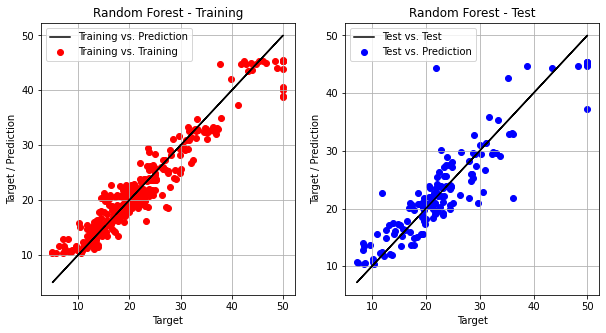

In [26]:
# load data
from sklearn import datasets
boston = datasets.load_boston()
X = boston.data
y = boston.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# First, test the performance of RF on the Boston house price dataset
#np.random.seed(seed=0)
boston_RF = RF(loss = 'mse', max_depth = 5, min_sample_split = 5, lamda = 1, gamma = 0, rf = 1, num_trees = 50)

boston_RF.fit(X_train, y_train)

y_pred_train = boston_RF.predict(X_train)
y_pred_test = boston_RF.predict(X_test)

print('RMSE (train):', root_mean_square_error(y_pred_train, y_train))
print('RMSE (test):', root_mean_square_error(y_pred_test, y_test))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(y_train, y_pred_train, c='r', label='Training vs. Training')
ax[0].plot(y_train, y_train, 'k-', label='Training vs. Prediction')
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('Target')
ax[0].set_ylabel('Target / Prediction')
ax[0].set_title('Random Forest - Training')

ax[1].scatter(y_test, y_pred_test, c='b', label='Test vs. Prediction')
ax[1].plot(y_test, y_test, 'k-', label='Test vs. Test')
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('Target')
ax[1].set_ylabel('Target / Prediction')
ax[1].set_title('Random Forest - Test')
fig.show()
plt.savefig('Problem_3_a_1')

# Attempt GDBT on boston_RF
# _____TODO__________

In [16]:
# TODO: GBDT classification on credit-g dataset

# load data
from sklearn.datasets import fetch_openml
X, y = fetch_openml('credit-g', version=1, return_X_y=True, data_home='credit/', as_frame=False)
y = np.array(list(map(lambda x: 1 if x == 'good' else 0, y)))

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# First, test the performance of RF on the credit-g dataset
credit_RF = RF(loss = 'log', max_depth = 5, min_sample_split = 5, lamda = 1, gamma = 0, rf = 1, num_trees = 50)

credit_RF.fit(X_train, y_train)

y_pred_train = credit_RF.predict(X_train)
y_pred_test = credit_RF.predict(X_test)

print('Credit-g Accuracy (train):', accuracy(y_pred_train, y_train)*100, '%')
print('Credit-g Accuracy (test):', accuracy(y_pred_test, y_test)*100, '%')

# Attempt GDBT on credit-g
# _____TODO__________

Accuracy (train): 80.0 %
Accuracy (test): 75.0 %


In [17]:
# TODO: GBDT classification on breast cancer dataset

# load data
from sklearn import datasets
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# First, test the performance of RF on the credit-g dataset
cancer_RF = RF(loss = 'log', max_depth = 5, min_sample_split = 5, lamda = 1, gamma = 0, rf = 1, num_trees = 50)

cancer_RF.fit(X_train, y_train)

y_pred_train = cancer_RF.predict(X_train)
y_pred_test = cancer_RF.predict(X_test)

print('Breast Cancer Accuracy (train):', accuracy(y_pred_train, y_train)*100, '%')
print('Breast Cancer Accuracy (test):', accuracy(y_pred_test, y_test)*100, '%')

Accuracy (train): 98.74371859296483 %
Accuracy (test): 95.90643274853801 %
